# Injector Optimization at LCLS
Aiming to optimize transverse beam size with solenoid SQ, CQ and 6 Quads

In [1]:
# optionally add scripts location to path
if True:
    import sys
    sys.path.append("../../")
    sys.path.append("../")

run_dir = "/home/physics3/ml_tuning/20230821_LCLS_Injector/"
print(sys.path)

['/home/physics3/rroussel/SLAC_Xopt/lcls/optimization', '/usr/local/lcls/tools/python/toolbox', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python39.zip', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/lib-dynload', '', '/home/physics3/.local/lib/python3.9/site-packages', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages', '../../', '../']


## Set up image diagnostic

In [2]:
from scripts.image import ImageDiagnostic
import yaml

fname = "../OTR3_config.yml"
image_diagnostic = ImageDiagnostic.parse_obj(yaml.safe_load(open(fname)))
image_diagnostic.save_image_location = run_dir
image_diagnostic.n_fitting_restarts = 2
image_diagnostic.visualize = False
image_diagnostic.background_file = run_dir + "OTRS_IN20_621_background.npy"
print(image_diagnostic.yaml())

{screen_name: 'OTRS:IN20:621', array_data_suffix: IMAGE, array_n_cols_suffix: ROI_XNP,
  array_n_rows_suffix: ROI_YNP, resolution_suffix: RESOLUTION, beam_shutter_pv: 'IOC:BSY0:MP01:MSHUTCTL',
  background_file: /home/physics3/ml_tuning/20230821_LCLS_Injector/OTRS_IN20_621_background.npy,
  save_image_location: /home/physics3/ml_tuning/20230821_LCLS_Injector/, roi: null,
  min_log_intensity: 4.0, bounding_box_half_width: 3.0, wait_time: 0.1, n_fitting_restarts: 2,
  visualize: false, testing: false}



In [3]:
#image_diagnostic.measure_background(file_location=run_dir)

In [4]:
image_diagnostic.background_file

'/home/physics3/ml_tuning/20230821_LCLS_Injector/OTRS_IN20_621_background.npy'

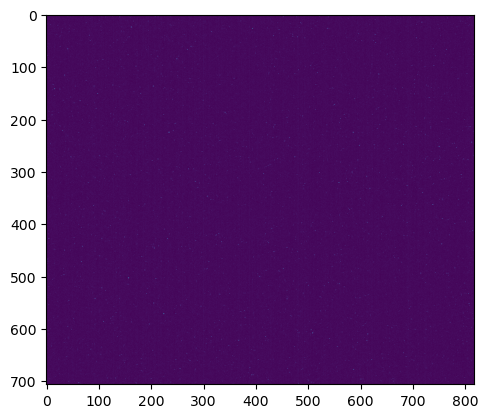

In [5]:
import matplotlib.pyplot as plt
plt.imshow(image_diagnostic.background_image)

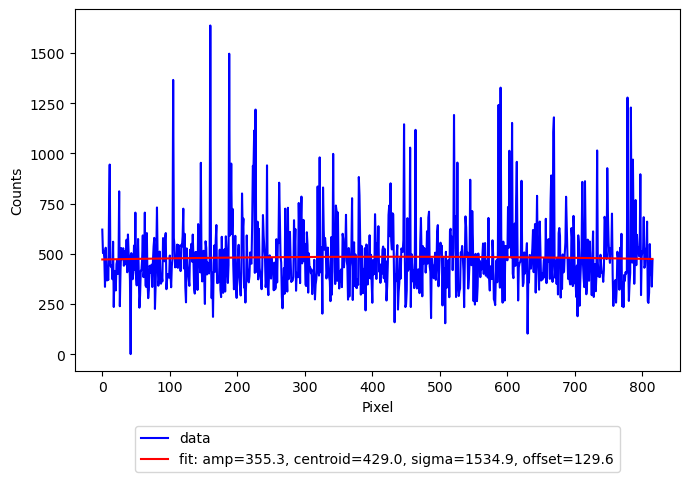

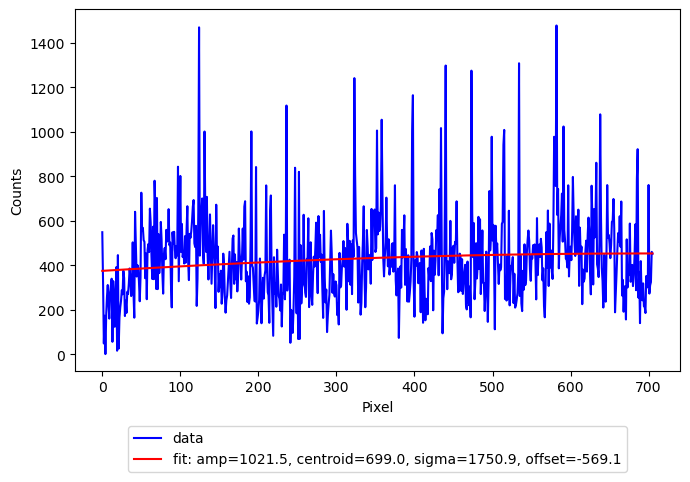

{'Cx': nan,
 'Cy': nan,
 'Sx': nan,
 'Sy': nan,
 'bb_penalty': 6902.474089947654,
 'total_intensity': 1275230.3999999994,
 'log10_total_intensity': 6.105588657247521}

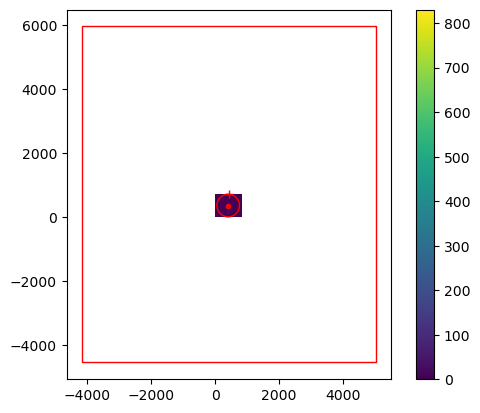

In [6]:
image_diagnostic.test_measurement()

In [7]:
import pandas as pd
filename = "../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')

In [8]:
IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
            "log10_total_intensity": ["GREATER_THAN", image_diagnostic.min_log_intensity]
        }

from xopt import VOCS
VARIABLES = ["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL","QUAD:IN20:122:BCTRL",'QUAD:IN20:361:BCTRL','QUAD:IN20:371:BCTRL','QUAD:IN20:425:BCTRL','QUAD:IN20:441:BCTRL','QUAD:IN20:511:BCTRL','QUAD:IN20:525:BCTRL']
vocs = VOCS(
        variables = {ele: VARIABLE_RANGES[ele] for ele in VARIABLES},
        constraints = IMAGE_CONSTRAINTS,
        objectives = {"total_size": "MINIMIZE"},
    )
print(vocs)

variables={'SOLN:IN20:121:BCTRL': [0.377, 0.498], 'QUAD:IN20:121:BCTRL': [-0.021, 0.021], 'QUAD:IN20:122:BCTRL': [-0.021, 0.021], 'QUAD:IN20:361:BCTRL': [-4.32, -1.08], 'QUAD:IN20:371:BCTRL': [1.09, 4.31], 'QUAD:IN20:425:BCTRL': [-7.56, -1.08], 'QUAD:IN20:441:BCTRL': [-1.08, 7.56], 'QUAD:IN20:511:BCTRL': [-1.08, 7.56], 'QUAD:IN20:525:BCTRL': [-7.56, -1.08]} constraints={'bb_penalty': ['LESS_THAN', 0.0], 'log10_total_intensity': ['GREATER_THAN', 4.0]} objectives={'total_size': 'MINIMIZE'} constants={} observables=[]


In [9]:
from epics import caput, caget_many
from time import sleep
import numpy as np
def eval_beamsize(inputs):
        global image_diagnostic
        # set PVs
        for k, v in inputs.items():
            print(f'CAPUT {k} {v}')
            caput(k, v)

        sleep(2.0)

        # get beam sizes from image diagnostic
        metadata = inputs
        results = image_diagnostic.measure_beamsize(5, **metadata)
        results["S_x_mm"] = np.array(results["Sx"]) * 1e-3
        results["S_y_mm"] = np.array(results["Sy"]) * 1e-3

        # get other PV's NOTE: Measurements not synchronous with beamsize measurements!
        results = results

        # add total beam size
        results["total_size"] = np.sqrt(np.array(results["Sx"]) ** 2 + np.array(results["Sy"]) ** 2)
        # results["total_size"] = np.sqrt(np.abs(np.array(results["Sx"])) * np.array(results["Sy"]))
        return results

In [10]:
from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

# remember to set use low noise prior to false!!!
model_constructor = StandardModelConstructor(use_low_noise_prior=False)
generator = UpperConfidenceBoundGenerator(
    vocs=vocs,
    model_constructor=model_constructor,
    turbo_controller="optimize"
)
generator.numerical_optimizer.max_iter = 200
# generator.max_travel_distances = [0.1] * len(vocs.variable_names)
evaluator = Evaluator(function=eval_beamsize)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.options.dump_file = run_dir + "turbo_optimization_2.yml"
X


            Xopt
________________________________
Version: 2.0a1+74.g9067c79
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: true, dump_file: /home/physics3/ml_tuning/20230821_LCLS_Injector/turbo_optimization_2.yml,
  max_evaluations: null}
generator:
  name: upper_confidence_bound
  model: null
  turbo_controller:
    dim: 9
    batch_size: 1
    length: 0.25
    length_min: 0.0078125
    length_max: 2.0
    failure_counter: 0
    failure_tolerance: 5
    success_counter: 0
    success_tolerance: 5
    center_x: null
    scale_factor: 2.0
    tkwargs: {dtype: torch.float64}
    minimize: true
    best_value: null
  use_cuda: false
  model_constructor:
    name: standard
    use_low_noise_prior: false
    covar_modules: {}
    mean_modules: {}
    trainable_mean_keys: []
  numerical_optimizer: {name: LBFGS, n_raw_samples: 20, n_restarts: 20, max_iter: 200}
  max_travel_distances: null
  fixed_features: null
  computation_time: {}
  n_candidates: 1
  n_monte_carlo_samples: 1

In [11]:
import pandas as pd

default = {'SOLN:IN20:121:BCTRL': 0.474877290758955,
 'QUAD:IN20:121:BCTRL': -0.0048398437,
 'QUAD:IN20:122:BCTRL': 0.0018,
 'QUAD:IN20:361:BCTRL': -3.16,
 'QUAD:IN20:371:BCTRL': 2.5352702,
 'QUAD:IN20:425:BCTRL': -1.1,
 'QUAD:IN20:441:BCTRL': -0.8118599,
 'QUAD:IN20:511:BCTRL': 3.6494056,
 'QUAD:IN20:525:BCTRL': -3.2522187,
}

X.evaluate_data(pd.DataFrame(default, index=[0]))

CAPUT SOLN:IN20:121:BCTRL 0.474877290758955
CAPUT QUAD:IN20:121:BCTRL -0.0048398437
CAPUT QUAD:IN20:122:BCTRL 0.0018
CAPUT QUAD:IN20:361:BCTRL -3.16
CAPUT QUAD:IN20:371:BCTRL 2.5352702
CAPUT QUAD:IN20:425:BCTRL -1.1
CAPUT QUAD:IN20:441:BCTRL -0.8118599
CAPUT QUAD:IN20:511:BCTRL 3.6494056
CAPUT QUAD:IN20:525:BCTRL -3.2522187


,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,Cx,...,Sy,bb_penalty,total_intensity,log10_total_intensity,save_filename,S_x_mm,S_y_mm,total_size,xopt_runtime,xopt_error
1,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,NaN,...,NaN,6595.874891,1183926.0,6.073325,/home/physics3/ml_tuning/20230821_LCLS_Injecto...,NaN,NaN,NaN,6.993356,False
1,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,NaN,...,NaN,1523.754477,1210305.0,6.082895,/home/physics3/ml_tuning/20230821_LCLS_Injecto...,NaN,NaN,NaN,6.993356,False
1,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,479.324935,...,136.386527,-145.364148,1245909.6,6.095487,/home/physics3/ml_tuning/20230821_LCLS_Injecto...,0.175659,0.136387,222.390057,6.993356,False
1,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,434.302864,...,68.269996,-197.397696,1230405.2,6.090048,/home/physics3/ml_tuning/20230821_LCLS_Injecto...,0.1566,0.06827,170.834342,6.993356,False
1,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,416.011502,...,113.030367,-215.463923,1244141.4,6.09487,/home/physics3/ml_tuning/20230821_LCLS_Injecto...,0.089256,0.11303,144.022452,6.993356,False


In [12]:
X.data

,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,Cx,...,Sy,bb_penalty,total_intensity,log10_total_intensity,save_filename,S_x_mm,S_y_mm,total_size,xopt_runtime,xopt_error
1,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,NaN,...,NaN,6595.874891,1183926.0,6.073325,/home/physics3/ml_tuning/20230821_LCLS_Injecto...,NaN,NaN,NaN,6.993356,False
2,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,NaN,...,NaN,1523.754477,1210305.0,6.082895,/home/physics3/ml_tuning/20230821_LCLS_Injecto...,NaN,NaN,NaN,6.993356,False
3,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,479.324935,...,136.386527,-145.364148,1245909.6,6.095487,/home/physics3/ml_tuning/20230821_LCLS_Injecto...,0.175659,0.136387,222.390057,6.993356,False
4,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,434.302864,...,68.269996,-197.397696,1230405.2,6.090048,/home/physics3/ml_tuning/20230821_LCLS_Injecto...,0.1566,0.06827,170.834342,6.993356,False
5,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,416.011502,...,113.030367,-215.463923,1244141.4,6.09487,/home/physics3/ml_tuning/20230821_LCLS_Injecto...,0.089256,0.11303,144.022452,6.993356,False


In [23]:
for i in range(10):
    print(i)
    X.step()

0
CAPUT QUAD:IN20:121:BCTRL 0.0014736093255430637
CAPUT QUAD:IN20:122:BCTRL 0.004126108364717016
CAPUT QUAD:IN20:361:BCTRL -2.97252086546508
CAPUT QUAD:IN20:371:BCTRL 2.0340351907716028
CAPUT QUAD:IN20:425:BCTRL -1.1683899360962633
CAPUT QUAD:IN20:441:BCTRL -0.22642271624428156
CAPUT QUAD:IN20:511:BCTRL 3.4037517477667554
CAPUT QUAD:IN20:525:BCTRL -3.1161700516785062
CAPUT SOLN:IN20:121:BCTRL 0.48025830965887595
1
CAPUT QUAD:IN20:121:BCTRL 0.0005767142930838804
CAPUT QUAD:IN20:122:BCTRL 0.006496625330864904
CAPUT QUAD:IN20:361:BCTRL -3.203919378847445
CAPUT QUAD:IN20:371:BCTRL 2.2015132396840795
CAPUT QUAD:IN20:425:BCTRL -1.658981369950133
CAPUT QUAD:IN20:441:BCTRL -0.3613202172842266
CAPUT QUAD:IN20:511:BCTRL 3.6550015708991213
CAPUT QUAD:IN20:525:BCTRL -3.1276140409031137
CAPUT SOLN:IN20:121:BCTRL 0.48560226409200663
2
CAPUT QUAD:IN20:121:BCTRL -0.001289678994974357
CAPUT QUAD:IN20:122:BCTRL 0.0018743258110594041
CAPUT QUAD:IN20:361:BCTRL -3.01657306336288
CAPUT QUAD:IN20:371:BCTRL 1

<Axes: >

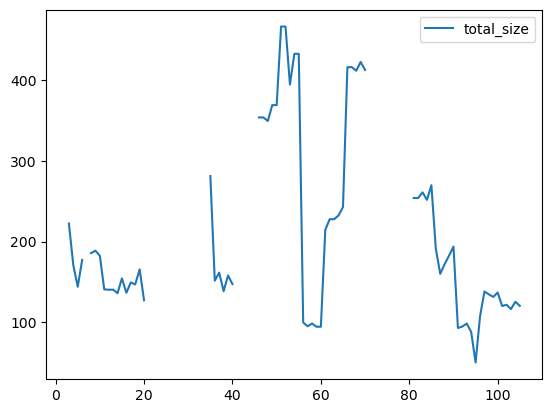

In [24]:
X.data.plot(y="total_size")

<Axes: >

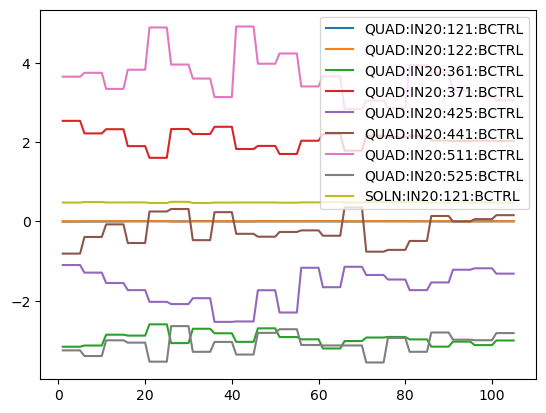

In [25]:
X.data.plot(y=X.vocs.variable_names)

QUAD:IN20:121:BCTRL [-0.0048398437, 0.007309855856176169]
QUAD:IN20:122:BCTRL [0.0014817256739646516, 0.006496625330864904]
QUAD:IN20:361:BCTRL [-3.203919378847445, -2.696401635137542]
QUAD:IN20:371:BCTRL [1.7002298179557025, 2.5352702]
QUAD:IN20:425:BCTRL [-2.5330024827272566, -1.1]
QUAD:IN20:441:BCTRL [-0.8118599, 0.35488714149509426]
QUAD:IN20:511:BCTRL [2.835229848032957, 4.2349335237397625]
QUAD:IN20:525:BCTRL [-3.3945175539934156, -2.718709284896754]
SOLN:IN20:121:BCTRL [0.4651160033624808, 0.488448540437686]


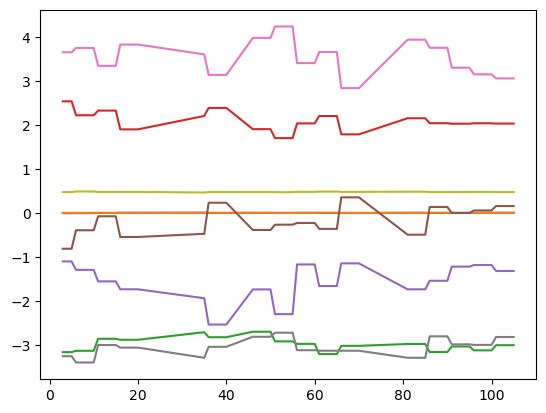

In [26]:
feasible = X.vocs.feasibility_data(X.data)["feasible"].values
for var_name in X.vocs.variable_names:
    X.data[var_name][feasible].plot()
    # print(var_name, X.vocs.variables[var_name])
    print(var_name, [X.data[var_name][feasible].min(), X.data[var_name][feasible].max()])

In [27]:
X.data.head()["total_size"].mean()

179.08228353260847

In [28]:
X.data.tail()["total_size"].mean()

120.88624955254826

In [29]:
X.data["total_size"].min()

50.33846070749141

In [30]:
from scripts.utils.read_files import read_file
res = read_file(X.data.iloc[10]["save_filename"])

In [ ]:
plt.imshow(res["images"][0])

In [ ]:
res